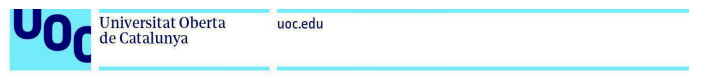

In [149]:
Image(filename='logo.png')

# 22.527 - Analítica de clientes
# PEC 1: Segmentación de clientes. Análisis Multivariante
## realizada por:  Alberto Rodríguez Álvarez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as pyo # exportar a Html
from IPython.display import Image
import seaborn as sns
from sklearn.impute import SimpleImputer
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('r1_2025.csv')
df_original = df
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length,gender
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,Y,3,F
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,N,2,M
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,N,3,M
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,N,2,M
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,Y,4,M


In [4]:
df.shape

(32581, 12)

## Análisis descriptivo del conjunto de datos.

In [6]:
na = df.isna().sum()
print(na[na>0])

person_emp_length     895
loan_int_rate        3116
dtype: int64


A pesar de que no se indica, se procede a eliminar los valores perdidos para poder realizar un análisis correcto.

In [8]:
df = df.dropna()

In [9]:
df.dtypes # muestra todos los tipo

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
gender                         object
dtype: object

In [10]:
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Hay un total de",len(numericas),"variables numéricas. Son:\n",numericas )

Hay un total de 7 variables numéricas. Son:
 ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'cb_person_cred_hist_length']


In [11]:
# descripción de las variables:
df.select_dtypes(include=['int64', 'float64']).describe().round(2)
# lo mismo que: df.describe().round(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,cb_person_cred_hist_length
count,28638.00,28638.00,28638.00,28638.00,28638.00,28638.00,28638.00
mean,27.73,66649.37,4.79,9656.49,11.04,0.22,5.79
std,6.35,62356.45,4.15,6329.68,3.23,0.41,4.04
min,20.00,4000.00,0.00,500.00,5.42,0.00,2.00
25%,23.00,39480.00,2.00,5000.00,7.90,0.00,3.00
50%,26.00,55956.00,4.00,8000.00,10.99,0.00,4.00
75%,30.00,80000.00,7.00,12500.00,13.48,0.00,8.00
max,177.00,6000000.00,123.00,35000.00,23.22,1.00,30.00


Antes de responder a las preguntas del enunciado, se puede observar que los datos tienen incongruencias que se deben tratar previamente.

· La variable *loan_status* no es numérica

· La edad tiene valores no válidos

· Analizar posibles valores extremos que alteran los datos



<Axes: xlabel='loan_status', ylabel='count'>

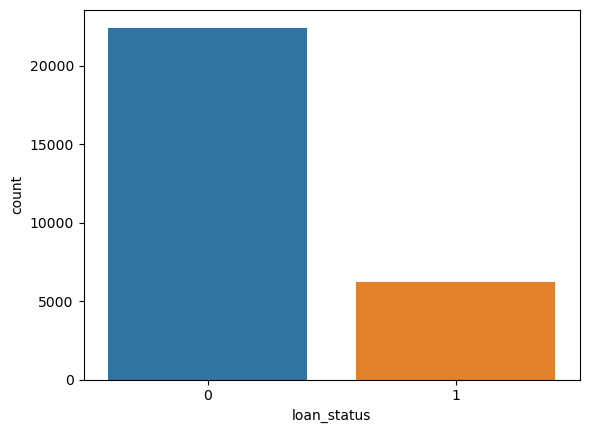

In [13]:
sns.countplot(data=df,x='loan_status')

In [14]:
# corrección del error de codificación de la variable.
df['loan_status'] = df['loan_status'].astype('category')

In [15]:
# con la correción pertinente obtenemos que:
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Hay un total de",len(numericas),"variables numéricas. Son:\n",numericas )

Hay un total de 6 variables numéricas. Son:
 ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length']


Se analizan valores atípicos:

<Axes: ylabel='person_income'>

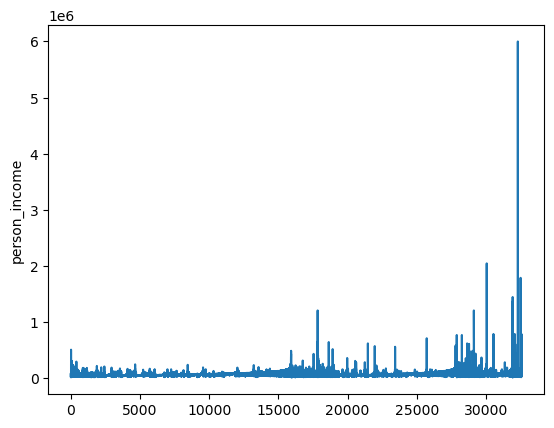

In [17]:
sns.lineplot(data=df, x=df.index, y='person_income')

In [18]:
df['person_income'].nlargest(5)

32297    6000000
30049    2039784
32497    1782000
31924    1440000
31922    1362000
Name: person_income, dtype: int64

In [19]:
# con el índice de posición previo obtenemos la fila.
df.loc[32297]

person_age                         144
person_income                  6000000
person_home_ownership         MORTGAGE
person_emp_length                 12.0
loan_intent                   PERSONAL
loan_grade                           C
loan_amnt                         5000
loan_int_rate                    12.73
loan_status                          0
cb_person_default_on_file            N
cb_person_cred_hist_length          25
gender                               M
Name: 32297, dtype: object

In [20]:
#La información de esta entrada nos muesta datos poco realistas. Es recomendable eliminar esta entrada.
df_clear = df.drop(32297)

In [21]:
# edad superior a 100 años la considero no apta para pedir un crédito bancario.
df['person_age'].nlargest(5)

575      177
81       144
183      144
32297    144
32506     84
Name: person_age, dtype: int64

In [22]:
df_clear = df.drop(df['person_age'].nlargest(4).index)

In [23]:
df_clear.describe().round(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
count,28634.00,28634.00,28634.00,28634.00,28634.00,28634.00
mean,27.71,66430.63,4.79,9656.58,11.04,5.79
std,6.17,51551.02,4.15,6329.65,3.23,4.04
min,20.00,4000.00,0.00,500.00,5.42,2.00
25%,23.00,39462.00,2.00,5000.00,7.90,3.00
50%,26.00,55900.00,4.00,8000.00,10.99,4.00
75%,30.00,80000.00,7.00,12500.00,13.48,8.00
max,84.00,2039784.00,123.00,35000.00,23.22,30.00


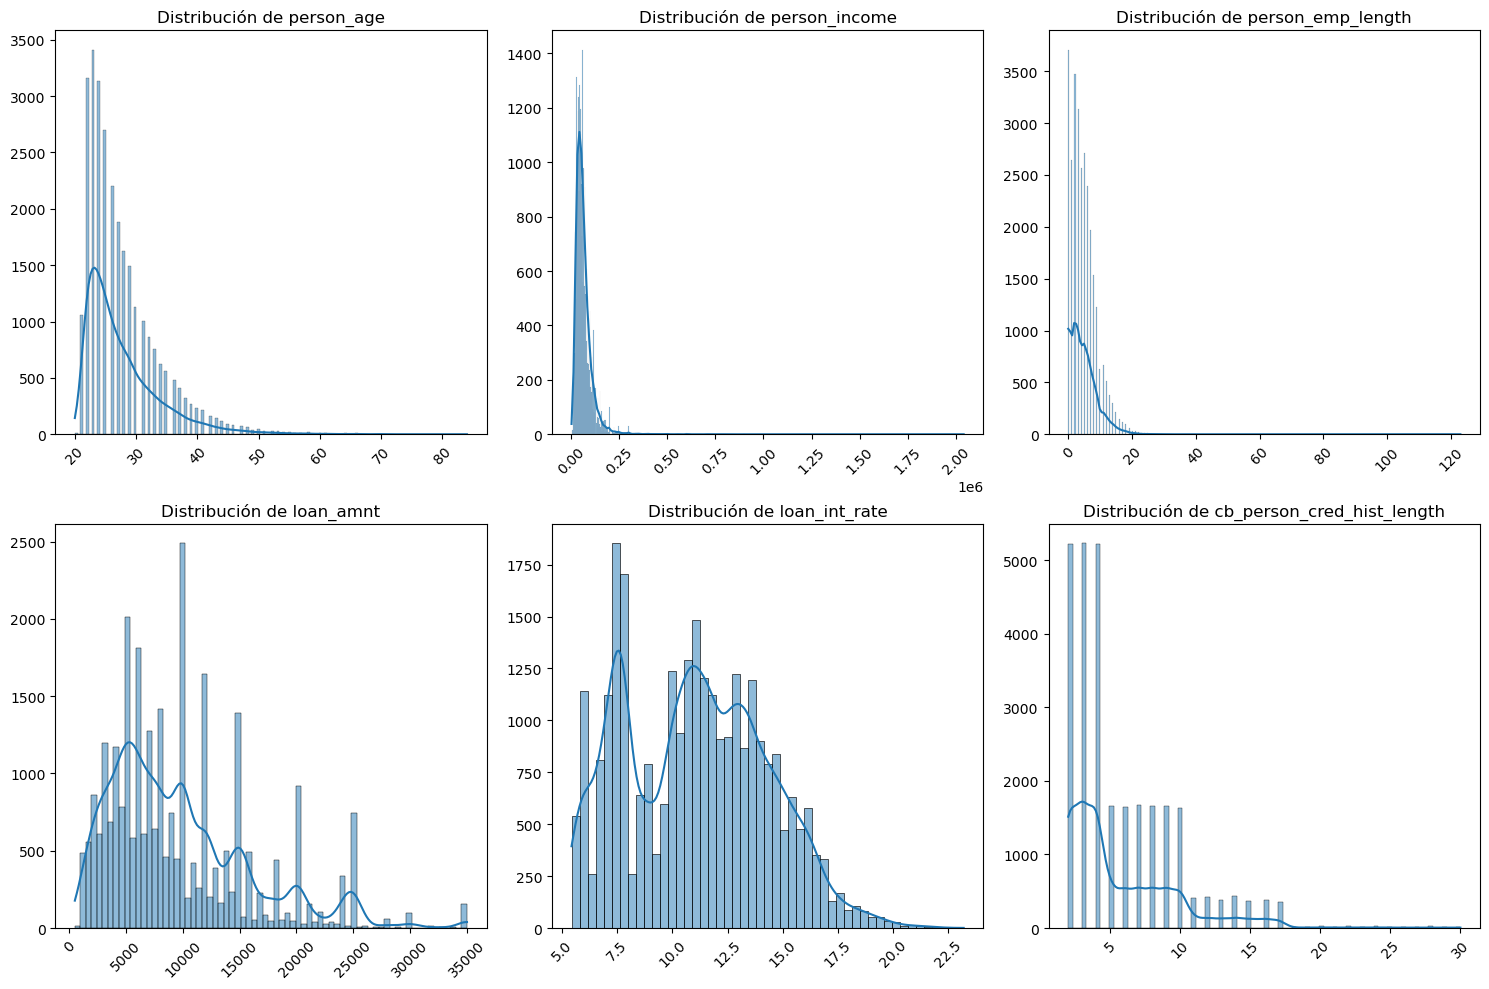

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, var in enumerate(numericas):
    sns.histplot(df_clear[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

Como se observa en los gráficos quedan posibles valores atípicos que valorar como los años de antigüedad como trabajador/a.

### variables categóricas

In [27]:
categoricas = df.select_dtypes(include=['object','category']).columns.tolist()
print("Hay un total de",len(categoricas),"variables categóricas. Son:\n",categoricas )

Hay un total de 6 variables categóricas. Son:
 ['person_home_ownership', 'loan_intent', 'loan_grade', 'loan_status', 'cb_person_default_on_file', 'gender']


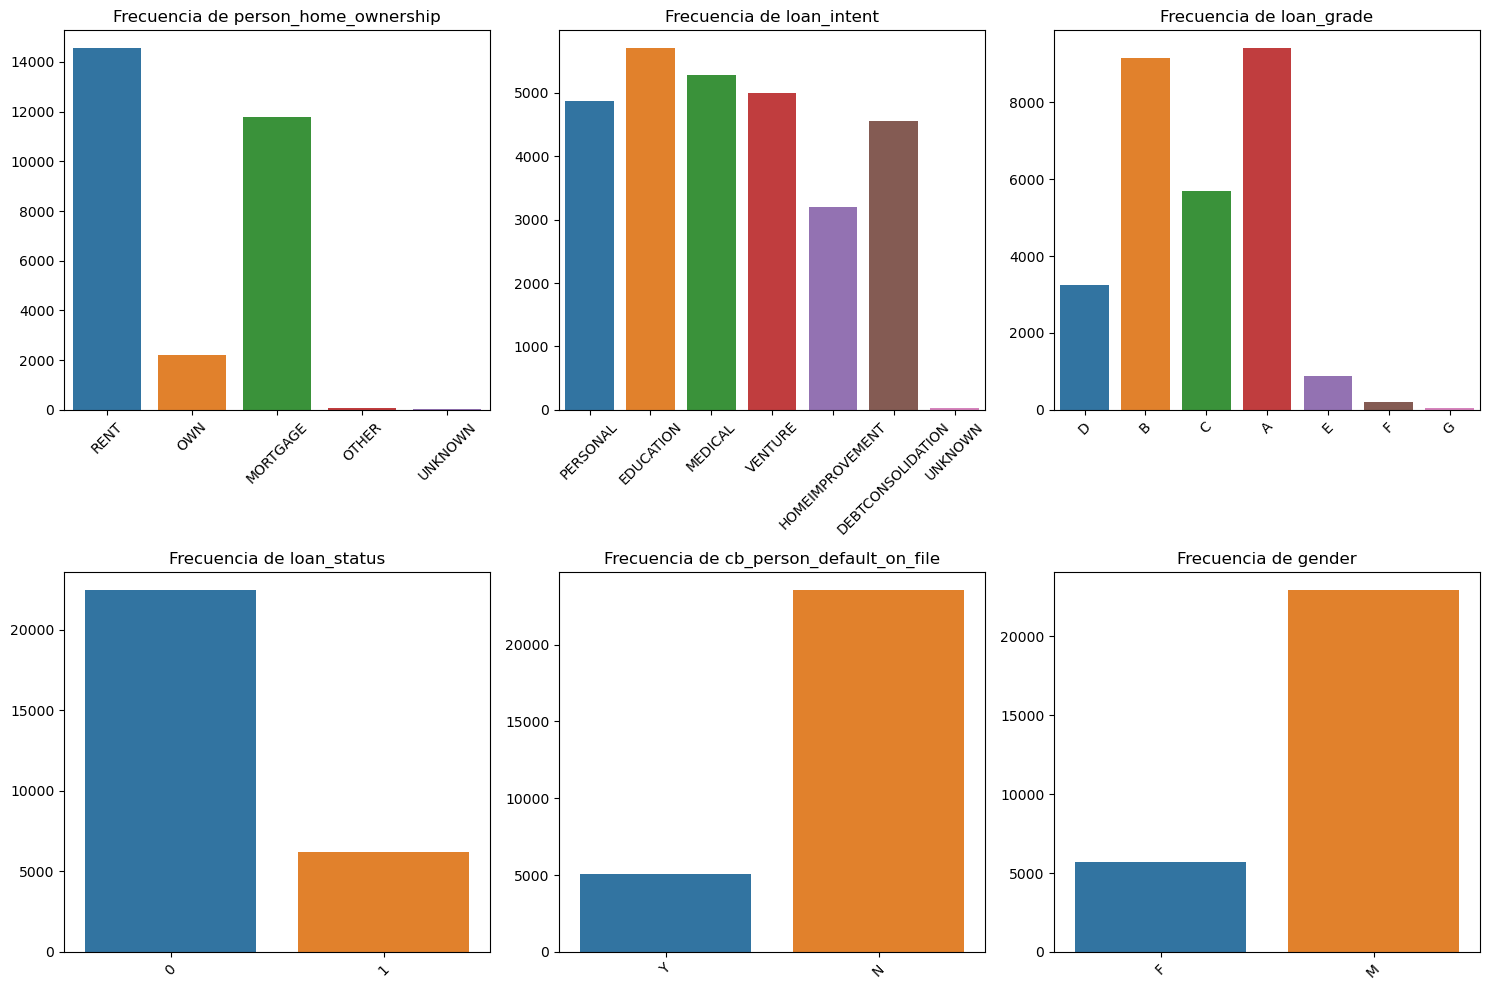

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# countplot de categoricas
for i, var in enumerate(categoricas):
    sns.countplot(x=var, data=df, ax=axes[i])
    axes[i].set_title(f'Frecuencia de {var}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Una vez realizado un primer análisis exploratório se procede a responder las preguntas del enunciado:**

1.a ) ¿Cuántas muestras y variables tiene el dataset? ¿Cuántas de ellas son
categóricas? ¿Y de numéricas?

In [32]:
print(f'El conjunto de datos proporcionado tiene {df_original.shape[0]} muestras y {df_original.shape[1]} variables')

El conjunto de datos proporcionado tiene 32581 muestras y 12 variables


In [33]:
print(f'El conjunto de datos despues de eliminar los valores nulos tiene **{df.shape[0]}** muestras')

El conjunto de datos despues de eliminar los valores nulos tiene **28638** muestras


Según la codificación por defecto que realiza pandas, el conjunto tiene 7 variables numéricas y 5 categóricas. Esto es incorrecto dado que codifica mal la variable *loan_status*. El conjunto de datos tiene **6 variables categóricas y 6 numéricas**.

In [35]:
# código que confirma la respuesa anterior.
print(len(df_original.select_dtypes(include=['int64', 'float64']).columns.tolist()),
len(df_original.select_dtypes(include=['object','category']).columns.tolist()))

7 5


1.b) ¿Cuántas filas con valores nulos tiene el dataset?

In [37]:
print(f'la respuesta es: {df_original.isnull().any(axis=1).sum()} filas. El total de valores nulos es mayor, concretamente {df_original.isnull().sum().sum()}')

la respuesta es: 3943 filas. El total de valores nulos es mayor, concretamente 4011


1.c) ¿Crees que el dataset tiene sesgos de género, es decir, crees que el dataset
representa a la población real? ¿Observas algo extraño?

In [39]:
(df['gender'].value_counts(normalize=True) * 100).round(2)

gender
M    80.01
F    19.99
Name: proportion, dtype: float64

Como se puede observar la proporción de generos no es equitativa, no hay paridad. Que exista este sesgo no implica que no sea una representación de la sociedad. Es posible que los datos estén representando una sociedad machista, en este caso si que representarían a la población real, por desagradable que esta sea. Se observa una gran desproporción de genero.

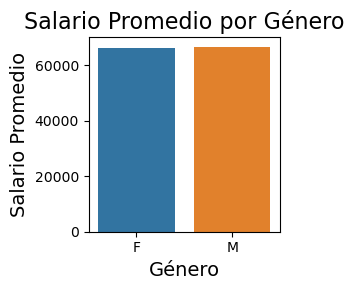

In [41]:
# Calcular el salario promedio por género
salario_genero = df.groupby('gender')['person_income'].mean().reset_index()

plt.figure(figsize=(3, 3))
sns.barplot(x='gender', y='person_income', data=df.groupby('gender')['person_income'].mean().reset_index())

plt.title('Salario Promedio por Género', fontsize=16)
plt.xlabel('Género', fontsize=14)
plt.ylabel('Salario Promedio', fontsize=14)
plt.tight_layout()
plt.show()

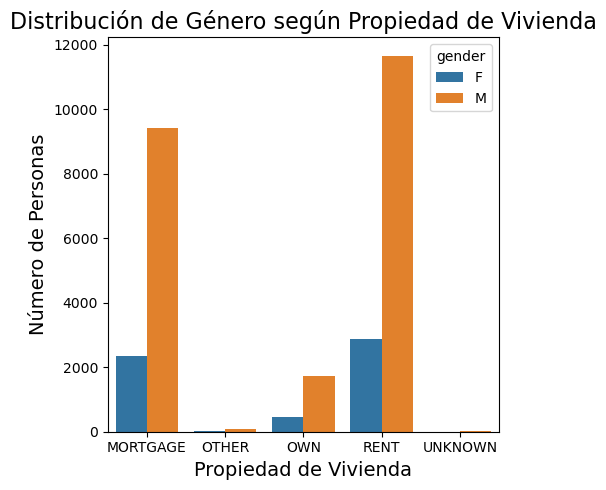

In [42]:
home_gender_count = df.groupby(['person_home_ownership', 'gender']).size().reset_index(name='count')

# Crear un gráfico de barras apiladas
plt.figure(figsize=(5, 5))
sns.barplot(x='person_home_ownership', y='count', hue='gender', data=home_gender_count)

# Personalizar el gráfico
plt.title('Distribución de Género según Propiedad de Vivienda', fontsize=16)
plt.xlabel('Propiedad de Vivienda', fontsize=14)
plt.ylabel('Número de Personas', fontsize=14)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Como se ha visto antes si la propia distribución del genero ya está sesgada... se contagia a todos los datos. Existe el sesgo en varios aspectos. Cabe destacar que en la muestra no existe sesgo en cuanto al salario, lo cual indica que la población de la muestra tienen un nivel socio-económico similar. Esta situación desgraciadamente no es habitual; el techo de cristal es una realidad en sociedades como la nuestra.

1.d) Categoría es “Unknown”.

En el supuesto que la variable Unknown no sea relevante (por su poco peso en los datos, por ejemplo) las opciones más utilizadas son reemplazar este valor por NaN (valor nulo o perdido) o imputarla. La primera opción implica una pérdida de datos y la segunda se utilizan estimaciones. Las estimaciones más utilizadas son: moda, mediana, media o valores próximos/similares (por grupo, categroria o métodos más elavorados como KNN o Hot Deck).

In [46]:
# imputar valores Unknown con su moda.
for col in categoricas:
    moda = df[col].mode()[0]
    df[col] = df[col].replace("UNKNOWN", moda)

In [47]:
df['person_home_ownership'].value_counts()

person_home_ownership
RENT        14565
MORTGAGE    11788
OWN          2191
OTHER          94
Name: count, dtype: int64

1.e) modifica Gender

In [49]:
df['gender'] = np.where(df['gender'] == 'M', 'Masc', df['gender'])
df['gender'] = np.where(df['gender'] == 'F', 'Fem', df['gender'])
df['gender'].value_counts()

gender
Masc    22912
Fem      5726
Name: count, dtype: int64

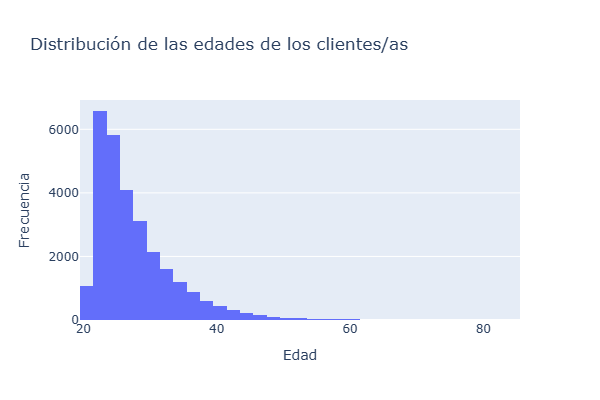

In [50]:
fig = px.histogram(df_clear, x='person_age', title="Distribución de las edades de los clientes/as", nbins=40)
fig.update_layout(width=600, height=400, xaxis_title='Edad', yaxis_title='Frecuencia')
#fig.show()
#pyo.iplot(fig)
Image(filename='newplot (0).png')

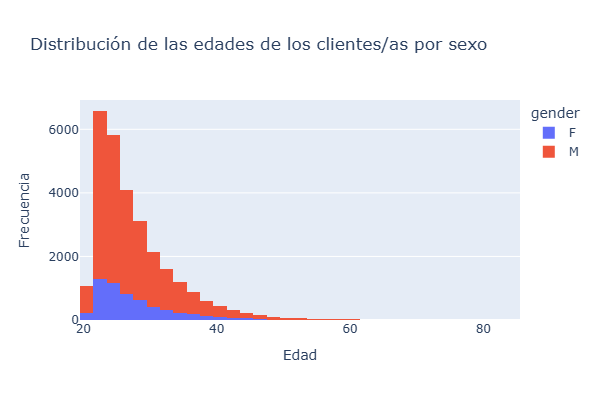

In [51]:
fig = px.histogram(df_clear, x='person_age', color='gender', title="Distribución de las edades de los clientes/as por sexo", nbins=40)
fig.update_layout(width=600, height=400, xaxis_title='Edad', yaxis_title='Frecuencia')
#fig.show()
#pyo.iplot(fig)
Image(filename='newplot (1).png')

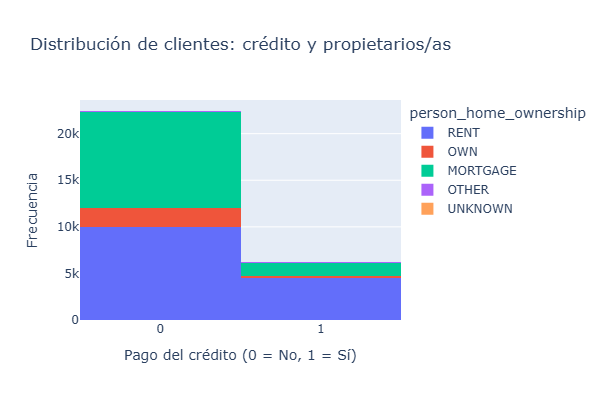

In [52]:
fig = px.histogram(df_clear, x='loan_status', color='person_home_ownership', title="Distribución de clientes: crédito y propietarios/as", barmode='stack')
fig.update_layout(width=600, height=400, xaxis_title='Pago del crédito (0 = No, 1 = Sí)', yaxis_title='Frecuencia', xaxis=dict(
        tickmode='array',
        tickvals=[0, 1]  # Esto asegura que solo se muestren los valores 0 y 1 en el eje X, sino queda raro
    ))
#fig.show()
#pyo.iplot(fig)
Image(filename='newplot (2).png')

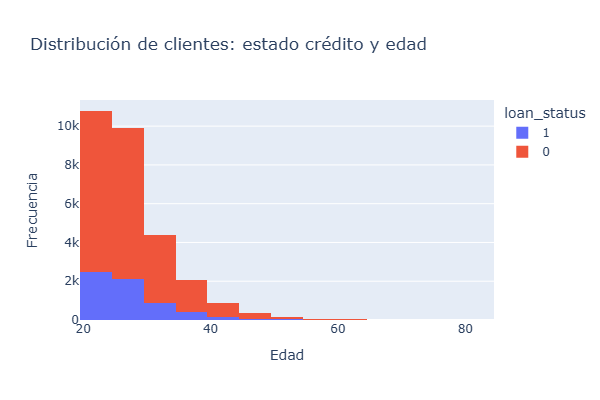

In [53]:
fig = px.histogram(df_clear, x='person_age', color='loan_status', title="Distribución de clientes: estado crédito y edad", nbins=20)
fig.update_layout(width=600, height=400,xaxis_title='Edad', yaxis_title='Frecuencia')
#fig4.show()
#pyo.iplot(fig)
Image(filename='newplot (3).png')

1.g) Rangos de edad

In [55]:
bins = range(0, df_clear['person_age'].max() + 15, 15)  # Definir los rangos de 15 en 15
labels = [f'{i}-{i+14}' for i in bins[:-1]]  # Etiquetas como '0-14', '15-29', etc.

df_clear['age_cat'] = pd.cut(df_clear['person_age'], bins=bins, labels=labels, right=False)


<Axes: xlabel='age_cat', ylabel='count'>

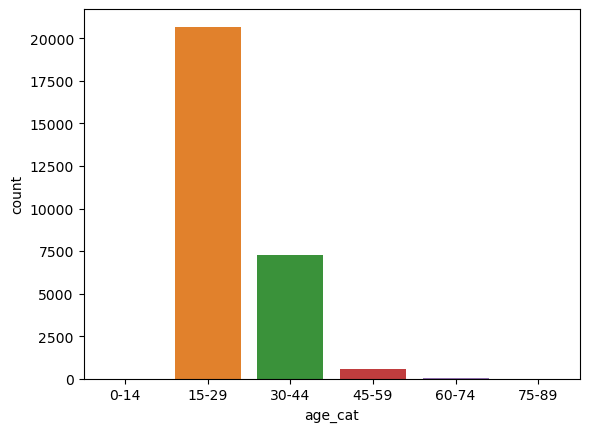

In [56]:
sns.countplot(x='age_cat', data=df_clear)

1.h)

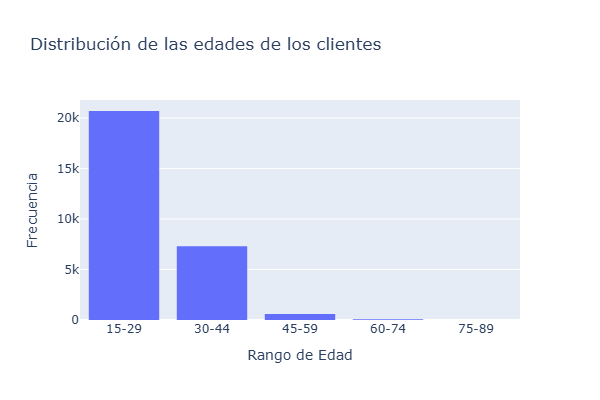

In [58]:
fig = px.histogram(df_clear, x='age_cat', title="Distribución de las edades de los clientes/as",
                    category_orders={'age_cat': sorted(df_clear['age_cat'].unique())})  # Ordenar los rangos
fig.update_layout(
    width=600,
    height=400,
    xaxis_title='Rango de Edad',
    yaxis_title='Frecuencia'
)
#pyo.iplot(fig)
#fig.show()
Image(filename='newplot (4).png')

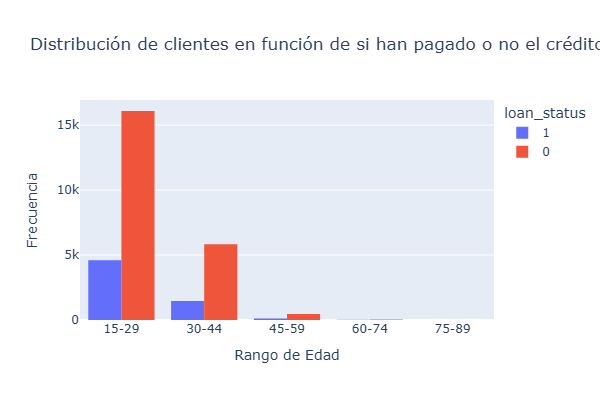

In [59]:
fig = px.histogram(df_clear, x='age_cat', color='loan_status', title="Distribución pagado o no el crédito por edad",
                    category_orders={'age_cat': sorted(df_clear['age_cat'].unique())}, barmode='group')
fig.update_layout(
    width=600,
    height=400,
    xaxis_title='Rango de Edad',
    yaxis_title='Frecuencia'
)
#fig.show()
#pyo.iplot(fig)
Image(filename='newplot (5).png')

In [174]:
((pd.crosstab(df_clear['age_cat'], df_clear['loan_status'], normalize='index') * 100).round(2)).rename(columns={0: 'No', 1: 'Yes'})

loan_status,No,Yes
age_cat,,
15-29,77.77,22.23
30-44,79.93,20.07
45-59,79.69,20.31
60-74,65.08,34.92
75-89,100.00,0.00


1. i j)

El análisis de las gráfica indica que en el proceso de EDA se deberían pulir un poco más los datos dado que aun exisen valores extremos que provocan que las gráficas no sean del todo eficientes. Por otro lado, al no disponer de leyenda o explicación de las variables de origen, las interpretaciones pueden no ser acertadas. La interpretacion de *loan_status* por ejemplo puede no ser la correcta.

Por otro lado, gracias al análisis de los datos podemos observar como el sesgo de genéro no se presenta en la forma en la que estamos acostumbrados (nuestro própio sesgo personal). Esta es una de las grandes virtudes del análsis, buscar la objetividad sin sesgos. 

Como resultado general de las variables vemos que dado el procentage de *loan_status* el target idel sería la población joven, dado que representa el mayor volumen con un margen de riesgo similar en todas las franjas de edad.

# Ejercicio 2

2.a )

In [63]:
def print_corr():    
    numericas = df_clear.select_dtypes(include=['int64', 'float64']).columns
    correlation_matrix =  df_clear[numericas].corr().round(2)
    fig = px.imshow(correlation_matrix,
                    title="Matriz de Correlación",
                    color_continuous_scale='Viridis',
                    labels={'color': 'Correlación'},
                    text_auto=True,
                    aspect='auto',
                    width=800,
                    height=600)
    #fig.show()
    pyo.iplot(fig)

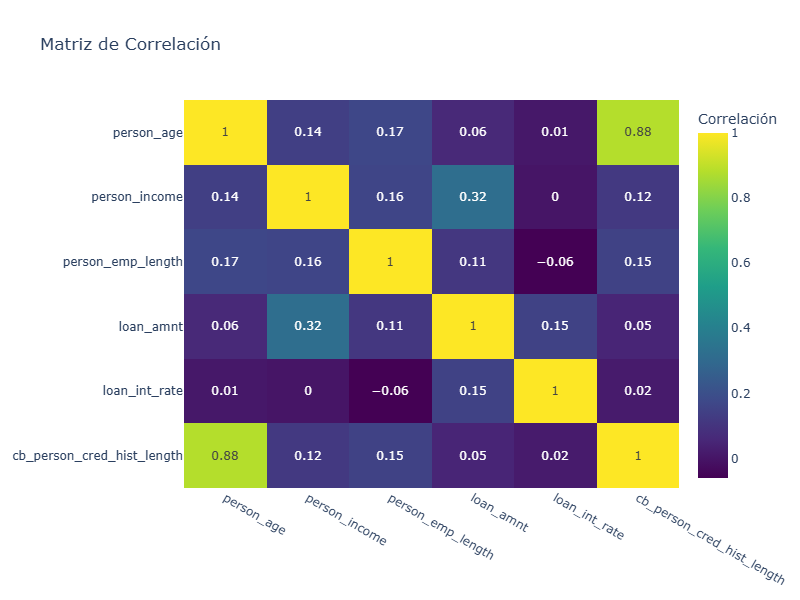

In [64]:
#print_corr()
Image(filename='newplot (6).png')

2.b ) crear una nueva variable llamada AvgLoanAmount

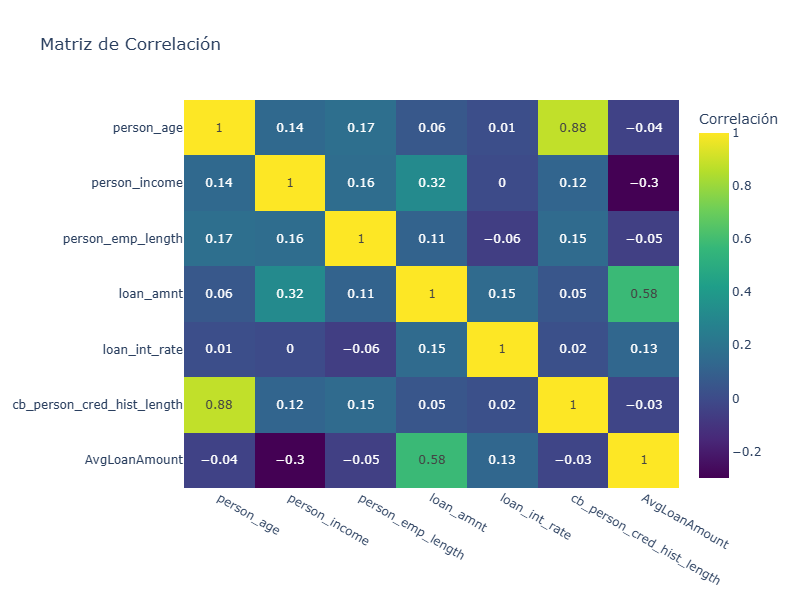

In [66]:
df_clear['AvgLoanAmount'] = (df_clear['loan_amnt'] / df_clear['person_income']) * 100
#print_corr()
Image(filename='newplot (7).png')

In [67]:
df_clear.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length,gender,age_cat,AvgLoanAmount
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,Y,3,F,15-29,59.322034
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,N,2,M,15-29,10.416667
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,N,3,M,15-29,57.291667
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,N,2,M,15-29,53.435115
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,Y,4,M,15-29,64.338235


Esta nueva dimensión si aporta valor, dado que este tipo de variable es útil porque refleja la relación entre el préstamo y los ingresos de una persona, lo cual puede ser relevante para analizar la capacidad de pago y el riesgo asociado a un cliente. Estos son unos de los principales estudios que se hacen a partir de estos datos. Es útil ya que los análisis predictivos pueden ofrecer información más relevante sobre el comportamiento de pago de los clientes al relacionar los ingresos con el monto del préstamo.

2.c )

1º la relación entre prestamo/ingresos, este ratio es util para analizar la capacidad del cliente/a para hacerse cargo de su deuda.
2º relación antigüedad / edad muestra la "estabilidad" o seriedad de la persona respecto mundo laboral. Aunque para que resultara más util sería preferible conocer el sector en el que trabaja.

2.d )

El *Análisis de Componentes Principales (PCA)* es una técnica de reducción de dimensionalidad que transforma un conjunto de variables correlacionadas en nuevas variables no correlacionadas llamadas componentes principales. Esta técnica es útil para simplificar modelos, mejorar su rendimiento al reducir el sobreajuste y facilitar la visualización de datos de alta dimensión. Sin embargo, PCA funciona mejor con datos numéricos, lo que significa que las variables categóricas del dataset deben ser previamente convertidas a un formato adecuado, como el one-hot encoding. Este paso podría incrementar la dimensionalidad, haciendo que el proceso sea más complejo. Además, PCA es sensible a la escala de las variables, por lo que es esencial escalar los datos antes de aplicarlo.

Aunque PCA puede mejorar la eficiencia en modelos con muchas variables correlacionadas, la interpretación de los componentes principales no siempre es sencilla. Por lo tanto, su aplicabilidad depende del tipo de datos y la tarea específica. En nuestro caso, podría ser útil para reducir la dimensionalidad de las variables numéricas, pero su efectividad en conjunto con variables categóricas transformadas depende de cómo afecte el rendimiento general del modelo.

2.e )

El *PCA y el t-SNE* son técnicas de reducción de dimensionalidad, pero tienen enfoques y aplicaciones diferentes. El PCA es un método lineal que busca transformar los datos en nuevas dimensiones de manera que se retenga la mayor parte de la varianza. Es ideal para reducir la dimensionalidad de grandes conjuntos de datos, preservando la estructura global y las relaciones lineales entre las variables. Sin embargo, su capacidad para capturar relaciones no lineales es limitada.

Por otro lado, t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica no lineal que se utiliza principalmente para visualización en 2D o 3D de datos de alta dimensión. Su objetivo es mantener las relaciones locales entre puntos de datos, agrupando instancias similares y separando las disimiles. Aunque es excelente para crear representaciones visuales comprensibles, t-SNE no es ideal para preprocesamiento de datos para modelos predictivos, ya que no preserva bien la estructura global y es computacionalmente costoso.

En este caso, si el objetivo es reducir la dimensionalidad para una mejor visualización de los datos, t-SNE sería la opción más adecuada. Si, en cambio, se busca reducir las dimensiones para mejorar el rendimiento de un modelo predictivo y preservar las relaciones globales, el PCA sería la técnica recomendada. Ambos métodos tienen sus ventajas y desventajas dependiendo del tipo de tarea a realizar, pero para tareas de visualización y comprensión de la estructura local de los datos, t-SNE es superior.

2.f ) Aplica la técnica de one-hot-encoding en las variables categóricas.

In [73]:
categoricas = df_clear.select_dtypes(include=['object','category']).columns.tolist()
categoricas

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'loan_status',
 'cb_person_default_on_file',
 'gender',
 'age_cat']

In [74]:
df_clear_encode = pd.get_dummies(df_clear, columns = categoricas, dtype='int')
df_clear_encode.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length,AvgLoanAmount,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,cb_person_default_on_file_N,cb_person_default_on_file_Y,gender_F,gender_M,age_cat_0-14,age_cat_15-29,age_cat_30-44,age_cat_45-59,age_cat_60-74,age_cat_75-89
0,22,59000,123.0,35000,16.02,3,59.322034,0,0,0,...,0,1,1,0,0,1,0,0,0,0
1,21,9600,5.0,1000,11.14,2,10.416667,0,0,1,...,1,0,0,1,0,1,0,0,0,0
2,25,9600,1.0,5500,12.87,3,57.291667,1,0,0,...,1,0,0,1,0,1,0,0,0,0
3,23,65500,4.0,35000,15.23,2,53.435115,0,0,0,...,1,0,0,1,0,1,0,0,0,0
4,24,54400,8.0,35000,14.27,4,64.338235,0,0,0,...,0,1,0,1,0,1,0,0,0,0


2.g )

Faltaría la normalización o estandarización de los datos para poder aplciar correctamente PCA.


In [76]:
scaler = StandardScaler()
df_scalado = pd.DataFrame(scaler.fit_transform(df_clear_encode))
df_scalado.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-0.925439,-0.144144,28.453226,4.003994,1.542129,-0.691953,3.969208,-0.836390,-0.05739,-0.287850,...,-2.147373,2.147373,2.000175,-2.000175,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
1,-1.087465,-1.102435,0.050890,-1.367648,0.031052,-0.939663,-0.615916,-0.836390,-0.05739,3.474035,...,0.465685,-0.465685,-0.499956,0.499956,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
2,-0.439364,-1.102435,-0.911901,-0.656696,0.566741,-0.691953,3.778851,1.195614,-0.05739,-0.287850,...,0.465685,-0.465685,-0.499956,0.499956,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
3,-0.763414,-0.018053,-0.189808,4.003994,1.297508,-0.939663,3.417280,-0.836390,-0.05739,-0.287850,...,0.465685,-0.465685,-0.499956,0.499956,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
4,-0.601389,-0.233377,0.772983,4.003994,1.000247,-0.444242,4.439502,-0.836390,-0.05739,-0.287850,...,-2.147373,2.147373,-0.499956,0.499956,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182


2.h ) Aplicar PCA. Dado que no se explicita, se aplica pca sin indicar ni buscar el numero adecuado de componentes.

In [78]:
# PCA 
pca = PCA()
resultado_pca = pca.fit_transform(df_scalado)
resultado_pca[:1]

array([[ 3.22360826e+00,  3.25915474e+00,  2.41891268e+00,
         2.71079021e+00,  9.23049720e+00, -9.73013425e-01,
         2.12116193e+00,  1.77188927e+00,  2.30820171e-01,
         2.23376393e+00,  1.72437945e-01, -2.40520255e+00,
         3.47053687e+00, -9.22943101e-01,  4.82892796e+00,
        -3.13543912e+00, -1.83365357e+00,  4.30152458e+00,
         2.84687155e+00,  3.01286379e-01, -1.31257221e+00,
         9.42059662e-01, -3.24980665e+00,  2.36743756e+01,
        -9.75723183e+00, -1.17554433e+00,  9.66681240e-01,
         5.69032338e-01, -7.31698524e-01, -1.32450929e-01,
         4.69042829e-13,  4.00083607e-15,  8.11367418e-16,
        -6.11869300e-16,  2.13991829e-17,  2.24915922e-16,
         2.85672722e-16,  5.45296376e-18]])

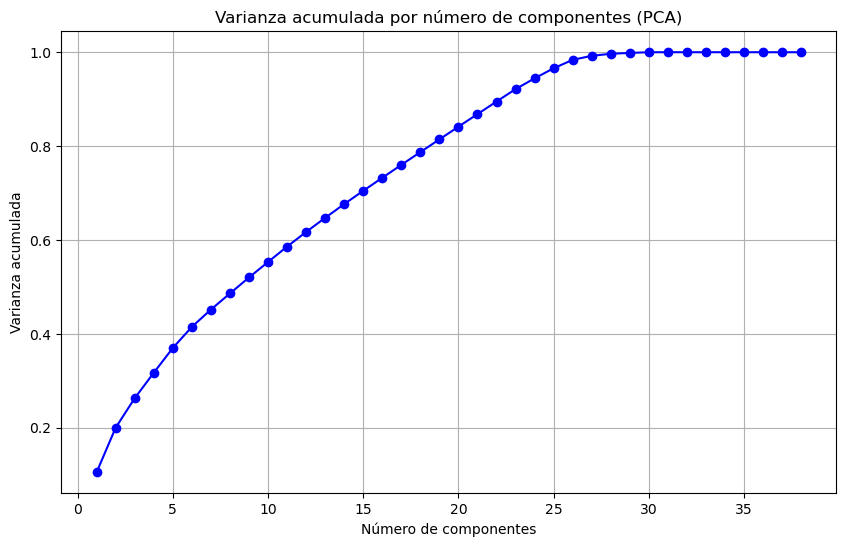

In [79]:
varianza = pca.explained_variance_ratio_
acumulada = varianza.cumsum()

# Graficamos la varianza acumulada vs el número de componentes
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(acumulada) + 1), acumulada, marker='o', linestyle='-', color='b')
plt.title('Varianza acumulada por número de componentes (PCA)')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

A partir de 25 componentes la aproximación es muy correcta. Sobre los 28 componentes ya no se pierden practicamente características del modelo.

2.i )  Con componentes = 2

In [82]:
pca = PCA(2)
resultado_pca = pca.fit_transform(df_scalado)
df_pca2 = pd.DataFrame(resultado_pca, columns=['comp1', 'comp2'])
df_pca2['loan_status'] = df_clear['loan_status']

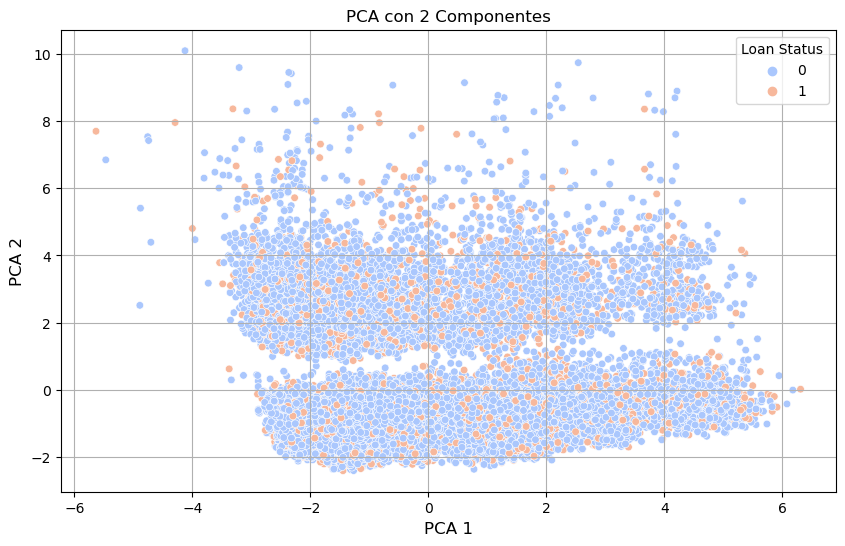

In [83]:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca2, x='comp1', y='comp2', hue='loan_status', palette='coolwarm', s=30)

# Añadir título y etiquetas
plt.title('PCA con 2 Componentes', fontsize=12)
plt.xlabel('PCA 1', fontsize=12)
plt.ylabel('PCA 2', fontsize=12)
plt.legend(title='Loan Status')
plt.grid(True)
plt.show()

2.j )

In [85]:
df_scalado

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-0.925439,-0.144144,28.453226,4.003994,1.542129,-0.691953,3.969208,-0.836390,-0.05739,-0.287850,...,-2.147373,2.147373,2.000175,-2.000175,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
1,-1.087465,-1.102435,0.050890,-1.367648,0.031052,-0.939663,-0.615916,-0.836390,-0.05739,3.474035,...,0.465685,-0.465685,-0.499956,0.499956,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
2,-0.439364,-1.102435,-0.911901,-0.656696,0.566741,-0.691953,3.778851,1.195614,-0.05739,-0.287850,...,0.465685,-0.465685,-0.499956,0.499956,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
3,-0.763414,-0.018053,-0.189808,4.003994,1.297508,-0.939663,3.417280,-0.836390,-0.05739,-0.287850,...,0.465685,-0.465685,-0.499956,0.499956,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
4,-0.601389,-0.233377,0.772983,4.003994,1.000247,-0.444242,4.439502,-0.836390,-0.05739,-0.287850,...,-2.147373,2.147373,-0.499956,0.499956,0.0,0.619856,-0.58469,-0.144543,-0.046958,-0.01182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28629,4.745437,-0.260535,-0.911901,-0.609299,0.656539,5.996233,-0.566532,1.195614,-0.05739,-0.287850,...,0.465685,-0.465685,-0.499956,0.499956,0.0,-1.613278,-0.58469,6.918344,-0.046958,-0.01182
28630,4.259362,1.039171,-0.189808,1.258927,-1.099160,3.271417,-0.215503,1.195614,-0.05739,-0.287850,...,0.465685,-0.465685,-0.499956,0.499956,0.0,-1.613278,-0.58469,6.918344,-0.046958,-0.01182
28631,6.041638,0.185632,-0.430506,4.003994,-0.015395,5.500812,2.725135,-0.836390,-0.05739,-0.287850,...,0.465685,-0.465685,-0.499956,0.499956,0.0,-1.613278,-0.58469,-0.144543,21.295726,-0.01182
28632,4.583412,1.621129,0.050890,0.844205,0.136332,5.005391,-0.654980,1.195614,-0.05739,-0.287850,...,0.465685,-0.465685,-0.499956,0.499956,0.0,-1.613278,-0.58469,6.918344,-0.046958,-0.01182


In [153]:
tsne = TSNE(n_components=2, random_state=42)


In [155]:
tsne_result = tsne.fit_transform(df_scalado)

In [159]:
df_tsne = pd.DataFrame(tsne_result, columns=['TSNE1', 'TSNE2'])
df_tsne['loan_status'] = df_clear['loan_status']


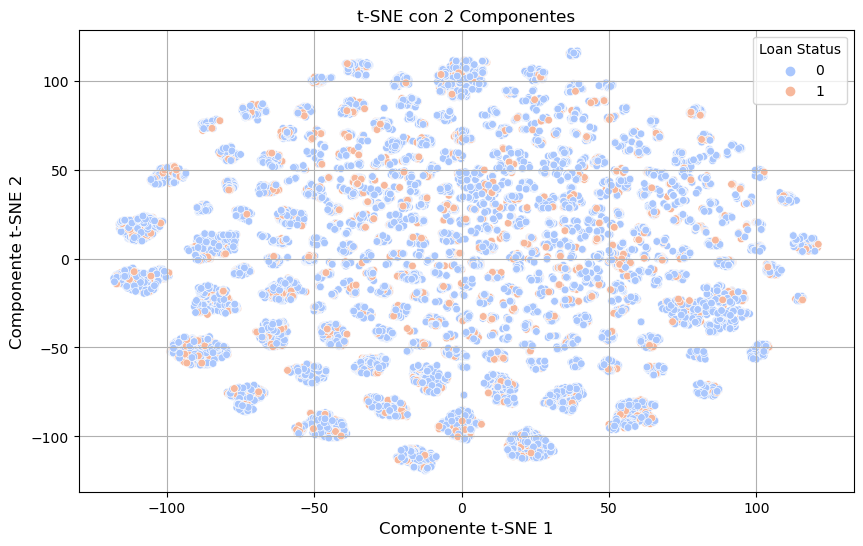

In [161]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='loan_status', palette='coolwarm', s=30)

plt.title('t-SNE con 2 Componentes', fontsize=12)
plt.xlabel('Componente t-SNE 1', fontsize=12)
plt.ylabel('Componente t-SNE 2', fontsize=12)
plt.legend(title='Loan Status')
plt.grid(True)
plt.show()

A continuación se adjunta el resultado de ejecutar el código de las celdas anteriores desde la plataforma Google Colab. Desde mi entorno de trabajo me ha sido imposible ejecutar este código dado que me da un error es posible que el error se deba a las versiónes de las diferentes libreias instaladas, dado que otro *env* permite su ejecución.

En el momento de realizar las últimas comprobaciones, la ejecución normal ha sido posible, igualmente se deja la imagen como prueba.

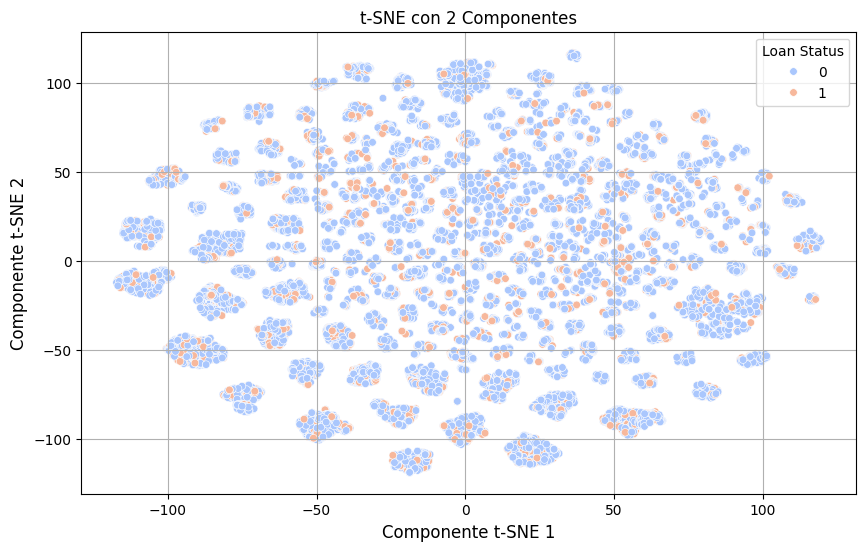

In [165]:
Image(filename='tsne.png')

2. k)

En el análisis de las representaciones visuales obtenidas mediante PCA y TSNE, se observan diferencias significativas en la distribución de los datos. El PCA (Análisis de Componentes Principales) mantiene la estructura global del dataset, reduciendo la dimensionalidad de manera lineal y preservando la mayor parte de la varianza. Sin embargo, al proyectar los datos en dos dimensiones, los puntos suelen distribuirse de forma más dispersa, sin una separación clara entre grupos, lo que puede dificultar la identificación de patrones específicos.

Por otro lado, el TSNE (t-Distributed Stochastic Neighbor Embedding) se enfoca en preservar las relaciones locales dentro de los datos, agrupando de manera más efectiva las observaciones similares. Esto se traduce en una representación visual donde los clusters aparecen más definidos, facilitando la detección de subgrupos y estructuras latentes dentro del conjunto de datos. Sin embargo, TSNE no conserva la estructura global, por lo que las distancias absolutas entre puntos pueden no ser interpretables en términos de varianza general.

En conclusión, el PCA es más adecuado cuando se busca reducir la dimensionalidad para modelado predictivo sin perder la coherencia estructural de los datos, mientras que TSNE resulta una herramienta más útil para análisis exploratorio y visualización de patrones ocultos.